# 02 Kernel Density for Wifind Projects
---

### Xiaomeng Dong

In [1]:
import urllib2
import json
import pandas as pd
import os
import numpy as np
import datetime as dt
from shapely.geometry import Point, Polygon
import geopandas as gpd
from fiona.crs import from_epsg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Functions handling datetime

In [2]:
def check(start_date, end_date):
    def checkdate(stamp):
        d = dt.datetime.fromtimestamp(stamp/1000.)
        if d >= start_date and d <= end_date:
            return True
        else:
            return False
    return checkdate

In [3]:
def todt(stamp):
    return dt.datetime.fromtimestamp(stamp/1000.)

## 1. Load wifi data collected.

In [6]:
# Data collected from 3:00pm to 5:00pm on 06/15/2017 

df1 = pd.read_csv('https://raw.githubusercontent.com/xd515/Wifind_file/master/dxm10000.csv')
start_date1 = dt.datetime(2017,6,15,15,0,0)
end_date1 = dt.datetime(2017,6,15,17,0,0)
df_dxm1 = df1[df1.time.apply(check(start_date1, end_date1))]
df_dxm1.reset_index(drop=True, inplace=True)
df_dxm1.head(1)

,idx,lat,lng,acc,altitude,time,device_mac,app_version,droid_version,device_model,ssid,bssid,caps,level,freq
0,56800549,40.693509,-73.981415,16.0,-11.0,1497558896000,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,downtownbrooklynwifi_fon,c4:10:8a:22:f4:f8,[ess],-58,2427


In [7]:
# Data collected from 4:00pm to 21:00 pm on 06/22/2017 

df2 = pd.read_csv('https://raw.githubusercontent.com/xd515/Wifind_file/master/dxm30000.csv')
start_date2 = dt.datetime(2017,6,20,16,0,0)
end_date2 = dt.datetime(2017,6,20,21,0,0)
df_dxm2 = df2[df2.time.apply(check(start_date2, end_date2))]
df_dxm2.reset_index(drop=True, inplace=True)
df_dxm2.head(1)

,idx,lat,lng,acc,altitude,time,device_mac,app_version,droid_version,device_model,ssid,bssid,caps,level,freq
0,56825737,40.691534,-73.985218,19.835,0.0,1498005108227,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,fios-23s,48:5d:36:b6:c2:86,[wpa2-psk-ccmp][wps][ess],-49,2437


In [8]:
# Concat two datasets

frames1 = [df_dxm1, df_dxm2]
result1 = pd.concat(frames1)
result1.head(1)

,idx,lat,lng,acc,altitude,time,device_mac,app_version,droid_version,device_model,ssid,bssid,caps,level,freq
0,56800549,40.693509,-73.981415,16.0,-11.0,1497558896000,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,downtownbrooklynwifi_fon,c4:10:8a:22:f4:f8,[ess],-58,2427


In [9]:
# Transform datasets to geometry data

result1['geo'] = zip(result1.lng, result1.lat)
result1['geometry'] = map(lambda x: Point(x), zip(result1.lng, result1.lat))
result1.head(1)

,idx,lat,lng,acc,altitude,time,device_mac,app_version,droid_version,device_model,ssid,bssid,caps,level,freq,geo,geometry
0,56800549,40.693509,-73.981415,16.0,-11.0,1497558896000,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,downtownbrooklynwifi_fon,c4:10:8a:22:f4:f8,[ess],-58,2427,"(-73.98141452, 40.69350921)",POINT (-73.98141452 40.69350921)


In [10]:
# Point out unique number of wifi access points
# For the same wifi ssid may have different bssid, the number is calculated by unique bssid here

print "Unique bssid of the wifi access point: ", result1.bssid.unique().shape

Unique bssid of the wifi access point:  (4994,)


## 2. Filter the points around housing projects

In [11]:
#Convert points to geodataframe

result2 = gpd.GeoDataFrame(result1, geometry = 'geometry')
result2.crs = from_epsg(4326)
result2.to_crs(epsg=2263, inplace=True)

In [12]:
# Outline the range of public housing projects

outline = Polygon([[-73.982483, 40.693547], [-73.982397, 40.695865], [-73.980369, 40.696199], [-73.973460, 40.695906], \
[-73.972880, 40.693221]])

In [13]:
# Filter points within the range of housing projects

result3 = result2[result2.geo.apply(Point).apply(outline.contains)]
result3.head(1)

,idx,lat,lng,acc,altitude,time,device_mac,app_version,droid_version,device_model,ssid,bssid,caps,level,freq,geo,geometry
41,56800513,40.69354,-73.981308,18.0,-10.2,1497558890000,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,downtownbrooklynwifi_fon,c4:10:8a:22:f4:f8,[ess],-58,2427,"(-73.98130804, 40.69354015)",POINT (989433.4243093401 191952.3774788328)


In [14]:
#df_dxm2['geo'] = zip(df_dxm2.lng, df_dxm2.lat)
#dxm = df_dxm2[df_dxm2.geo.apply(Point).apply(outline.contains)]
#dxm.head(1)
#filepath = '/Users/DXM/Documents/USI_2/Wifind_Data/'
#dxm.to_csv(filepath + '20170620_DXM.csv', index=False)

In [15]:
result4 = result3[['lat', 'lng', 'level','acc']]
result4.head(1)

,lat,lng,level,acc
41,40.69354,-73.981308,-58,18.0


## 3. Plot kernel density among housing projects


In [16]:
# Pull geometry data of housing projects

houses = gpd.GeoDataFrame.from_file('./Map of NYCHA Developments/geo_export_4a7ee29e-89c3-4303-acec-d52730808feb.shp')
blocks = gpd.GeoDataFrame.from_file('./2010 Census Blocks/geo_export_5941db01-e470-4456-93eb-655cba178afe.shp')

#houses.crs = from_epsg(2263)
#houses.to_crs(epsg=43, inplace=True)
houses.head(1)

,tds_num,developmen,borough,geometry
0,213,FHA REPOSSESSED HOUSES (GROUP III),VARIOUS,(POLYGON ((-73.93559146071932 40.6594891659253...


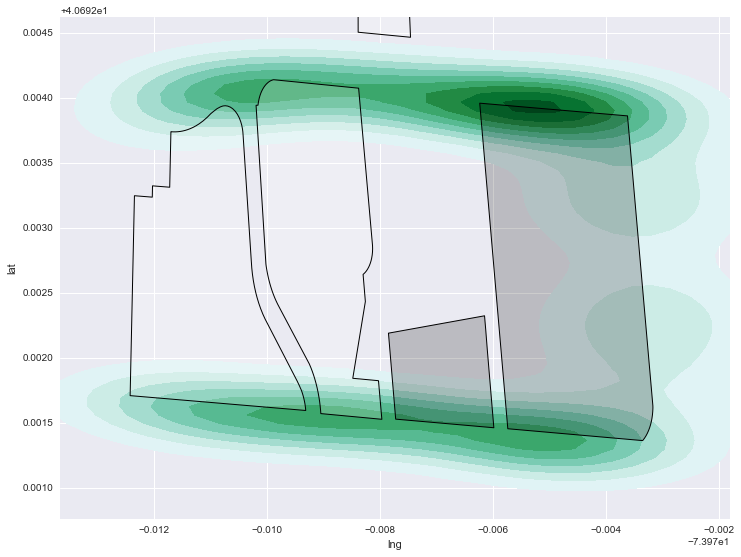

In [17]:
# Kernel density of wifi access points around housing projects

fig, ax = plt.subplots(figsize=(12,9))
ax = sns.kdeplot(df_dxm2['lng'], df_dxm2['lat'], 
                 gridsize= 100, bw = 'scott', shade = True, kernel = 'gau', shade_lowest=False,
                 legend = True, zorder=1)
houses.plot(ax = ax, alpha=0.2, zorder=2)
#blocks.plot(ax = ax, alpha=0.2, zorder=2)
#ax.get_xlim(), ax.get_ylim()

plt.xlim(-73.983660088701654, -73.971813621298352)
plt.ylim(40.692762589021697, 40.696623770978306)
plt.show()

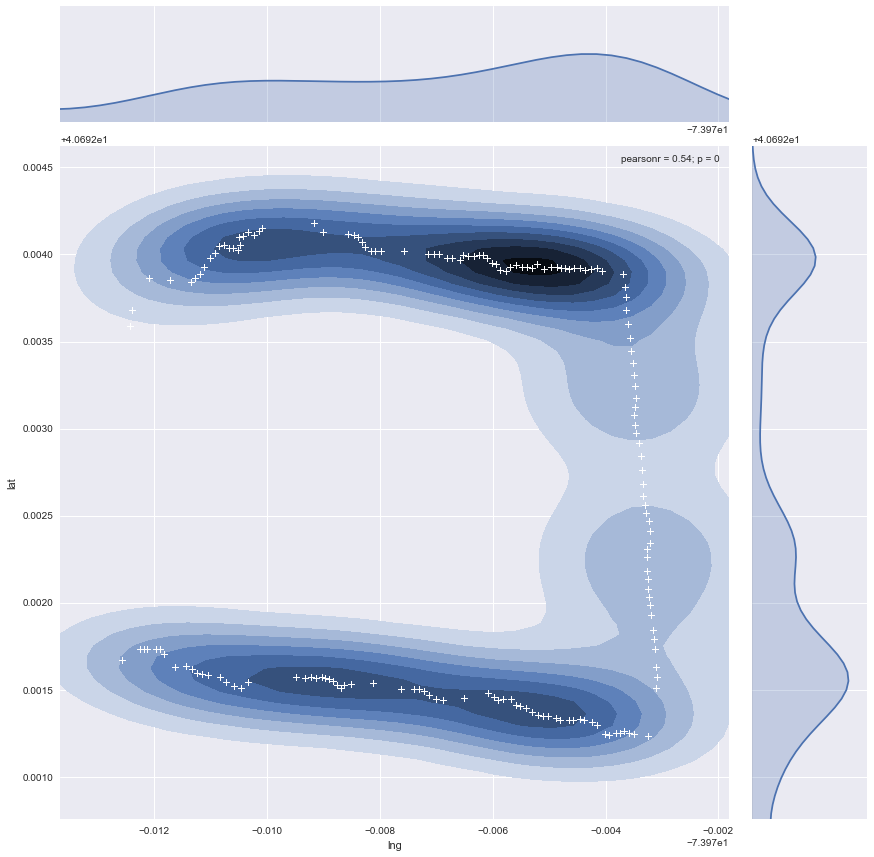

In [18]:
ax_all = sns.jointplot(x=df_dxm2['lng'], y=df_dxm2['lat'],size =12, kind="kde")
ax_all.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
ax_all.ax_joint.collections[0].set_alpha(0)
plt.xlim(-73.983660088701654, -73.971813621298352)
plt.ylim(40.692762589021697, 40.696623770978306)
plt.show()

In [28]:
# Find out the free wifi 

free_wifi=['#flatiron free wifi', 'freewifibysurface','bryantpark.org', 'downtownbrooklynwifi_fon',
'linknyc free wi-fi', 'metrotech','usp park wifi', 'red hook wifi']

free_points = result3[result3.ssid.isin(free_wifi)]
free_points.head()



,idx,lat,lng,acc,altitude,time,device_mac,app_version,droid_version,device_model,ssid,bssid,caps,level,freq,geo,geometry
41,56800513,40.69354,-73.981308,18.0,-10.2,1497558890000,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,downtownbrooklynwifi_fon,c4:10:8a:22:f4:f8,[ess],-58,2427,"(-73.98130804, 40.69354015)",POINT (989433.4243093401 191952.3774788328)
42,56800514,40.69354,-73.981308,18.0,-10.2,1497558890000,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,downtownbrooklynwifi_fon,c4:10:8a:22:f4:fc,[ess],-80,5220,"(-73.98130804, 40.69354015)",POINT (989433.4243093401 191952.3774788328)
43,56800515,40.69354,-73.981308,18.0,-10.2,1497558890000,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,downtownbrooklynwifi_fon,c4:10:8a:22:f5:b8,[ess],-50,2412,"(-73.98130804, 40.69354015)",POINT (989433.4243093401 191952.3774788328)
44,56800516,40.69354,-73.981308,18.0,-10.2,1497558890000,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,downtownbrooklynwifi_fon,c4:10:8a:22:f5:bc,[ess],-68,5240,"(-73.98130804, 40.69354015)",POINT (989433.4243093401 191952.3774788328)
46,56800518,40.69354,-73.981308,18.0,-10.2,1497558890000,b883c7e343eb726c,0.3.3,5.1.1,Nexus 4,downtownbrooklynwifi_fon,c4:10:8a:21:df:cc,[ess],-89,5220,"(-73.98130804, 40.69354015)",POINT (989433.4243093401 191952.3774788328)


In [57]:
free = free_points.ssid.value_counts().reset_index()
free.rename(columns={'ssid':'counts', 'index':'ssid'}, inplace=True)
free

,ssid,counts
0,downtownbrooklynwifi_fon,1100


In [61]:
free_points.level.median()

-80.0

In [29]:
# Point out unique number of free wifi access points

print "Unique ssid of the free wifi access point: ", free_points.ssid.unique()

Unique ssid of the free wifi access point:  ['downtownbrooklynwifi_fon']


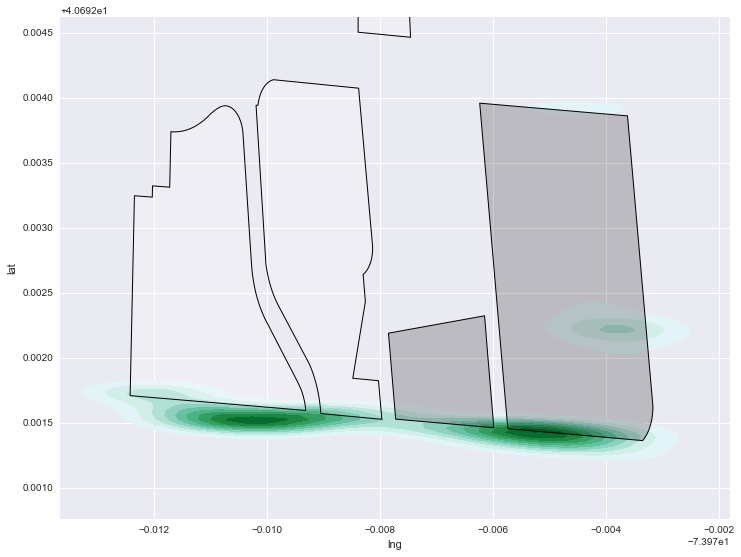

In [30]:
# Kernel density of free wifi access points around housing projects

fig, ax_free = plt.subplots(figsize=(12,9))
ax_free = sns.kdeplot(free_points['lng'], free_points['lat'], 
                 gridsize= 100, bw = 'scott', shade = True, kernel = 'gau', shade_lowest=False,
                 legend = True, zorder=1)
houses.plot(ax = ax_free, alpha=0.2, zorder=2)

#ax.get_xlim(), ax.get_ylim()

plt.xlim(-73.983660088701654, -73.971813621298352)
plt.ylim(40.692762589021697, 40.696623770978306)
plt.show()

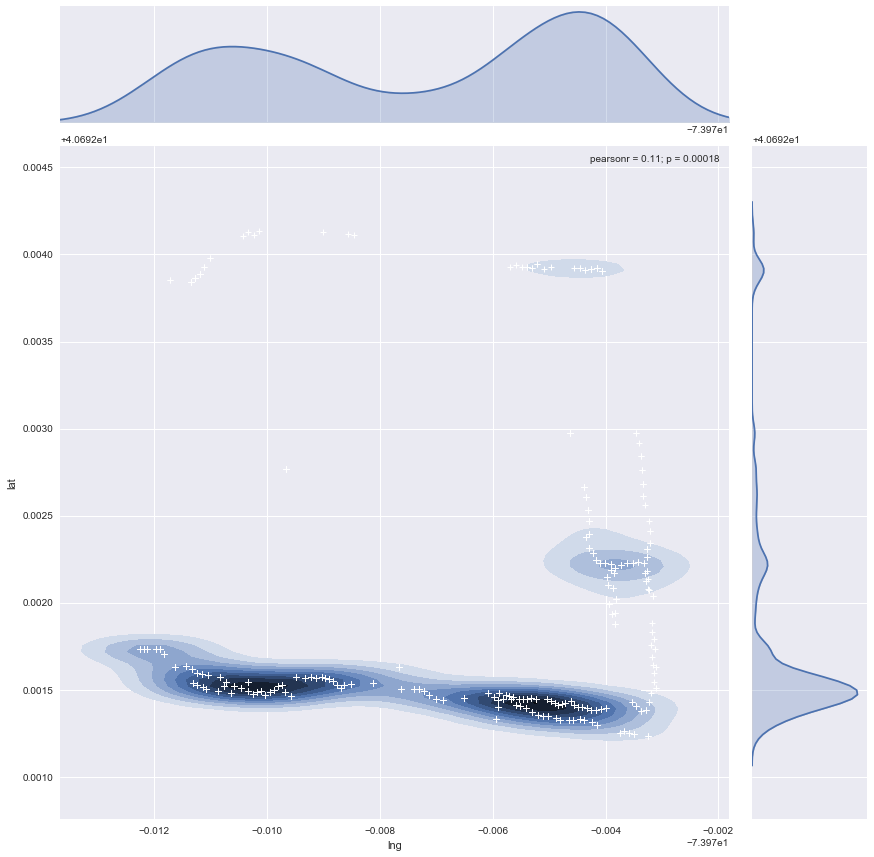

In [31]:
ax_part = sns.jointplot(x=free_points['lng'], y=free_points['lat'],size = 12, kind="kde")
ax_part.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
ax_part.ax_joint.collections[0].set_alpha(0)
plt.xlim(-73.983660088701654, -73.971813621298352)
plt.ylim(40.692762589021697, 40.696623770978306)
plt.show()

In [66]:
sns.jointplot?

## 4. Plot data of DJ

In [39]:
# Read File
df = pd.read_csv('/Users/DXM/Documents/USI_2/Wifind_Data/motoG4_062212.csv')

# convert Unix timestamp into readable timestamp
df['time2'] = map(lambda x: dt.datetime.fromtimestamp(x), df.time.astype(float)/1000)
df['month'] = map(lambda x: x.month, df['time2'])
df['day'] = map(lambda x: x.day, df['time2'])
df['hour'] = map(lambda x: x.hour, df['time2'])
df['minute'] = map(lambda x: x.minute, df['time2'])
df['sec'] = map(lambda x: x.second, df['time2'])

# Filter data according to datetime -> ! INPUT DATETIME MANUALLY
df2 = df.copy()
df2 = df2[((df2['month'] == 6) & (df2['day'] == 14)) | 
          ((df2['month'] == 6) & (df2['day'] == 22) & (df2['hour'] <10))]

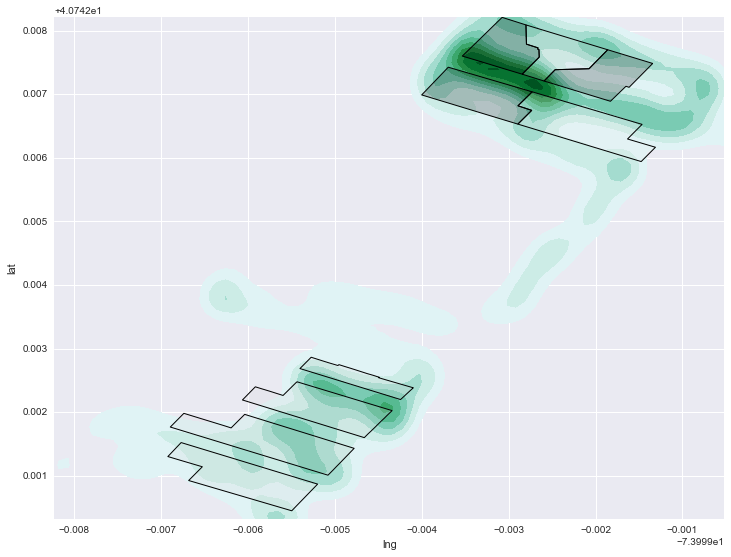

In [40]:
# Kernel density of wifi access points around housing projects

fig, ax_dj = plt.subplots(figsize=(12,9))
ax_dj = sns.kdeplot(df2['lng'], df2['lat'], 
                 gridsize= 100, bw = 'scott', shade = True, kernel = 'gau', shade_lowest=False,
                 legend = True, zorder=1)
houses.plot(ax = ax_dj, alpha=0.2, zorder=2)

#ax.get_xlim(), ax.get_ylim()
#(40.743473, -74.007224); (40.749114, -73.999522); 
#(40.750219, -74.002348); (40.742326, -74.004468)

plt.xlim(-74.007224, -73.999522)
plt.ylim(40.742326, 40.750219)
plt.show()

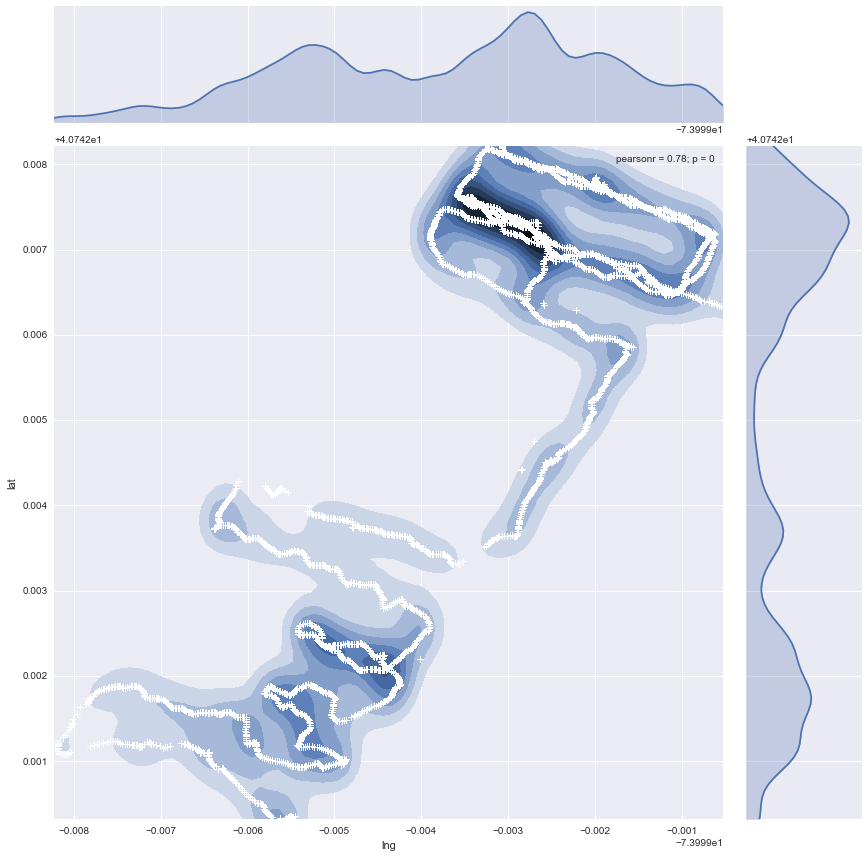

In [52]:
ax_dj_all = sns.jointplot(x=df2['lng'], y=df2['lat'],size =12, kind="kde")
ax_dj_all.ax_joint.collections[0].set_alpha(0.2)
ax_dj_all.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
plt.xlim(-74.007224, -73.999522)
plt.ylim(40.742326, 40.750219)
plt.show()

## 5. Plot data of zj.

In [4]:
df3 = pd.read_csv('/Users/DXM/Documents/USI_2/Wifind_Data/zj.csv')
start_date3 = dt.datetime(2017,6,22,16,0,0)
end_date3 = dt.datetime(2017,6,22,18,0,0)
df_zj = df3[df3.time.apply(check(start_date3, end_date3))]
df_zj.reset_index(drop=True, inplace=True)
df_zj.head(1)

,idx,lat,lng,acc,altitude,time,device_mac,app_version,droid_version,device_model,ssid,bssid,caps,level,freq
0,57029357,40.675183,-74.006922,22.328,0.0,1498166973881,300dd87905419eba,0.3.3,5.0,ASUS_T00P,jies iphone,7e:50:49:61:cf:a2,[wpa2-psk-ccmp][ess],-21,2437


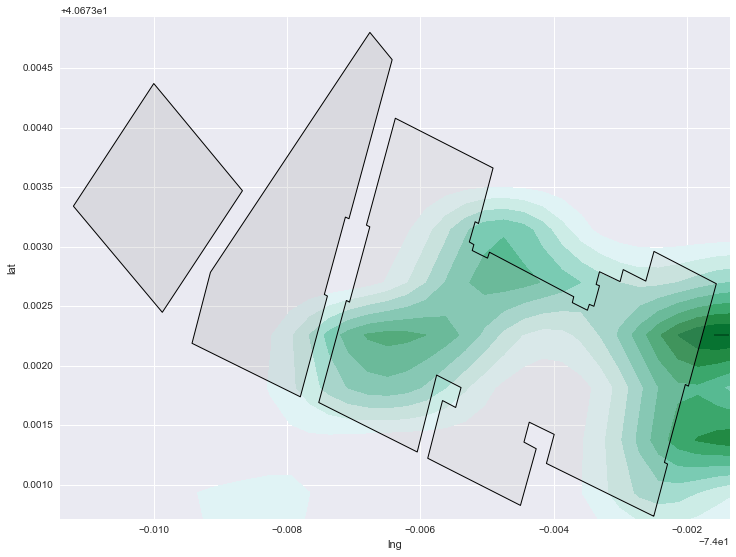

In [32]:
# Kernel density of wifi access points around housing projects

fig, ax_zj = plt.subplots(figsize=(12,9))
ax_zj = sns.kdeplot(df_zj['lng'], df_zj['lat'], 
                 gridsize= 100, bw = 'scott', shade = True, kernel = 'gau', shade_lowest=False,
                 legend = True, zorder=1)
houses.plot(ax = ax_zj, alpha=0.2, zorder=2)
#blocks.plot(ax = ax, alpha=0.2, zorder=2)
#ax.get_xlim(), ax.get_ylim()
#(40.676299, -74.011417)
#(40.673711, -74.004443)
#(40.675729, -74.001353)
#(40.677934, -74.006782)

plt.xlim(-74.011417, -74.001353)
plt.ylim(40.6737117, 40.677934)
plt.show()

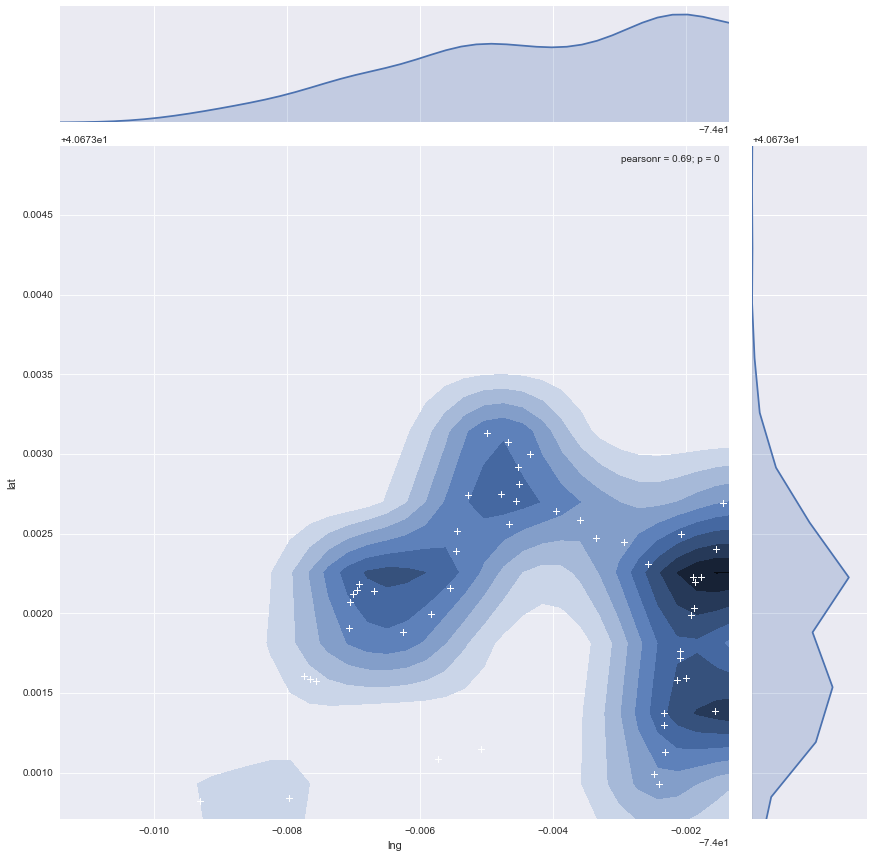

In [33]:
ax_zj_all = sns.jointplot(x=df_zj['lng'], y=df_zj['lat'],size =12, kind="kde")
ax_zj_all.ax_joint.collections[0].set_alpha(0.2)
ax_zj_all.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
plt.xlim(-74.011417, -74.001353)
plt.ylim(40.6737117, 40.677934)
plt.show()

In [49]:
free_wifi=['#flatiron free wifi', 'freewifibysurface','bryantpark.org', 'downtownbrooklynwifi_fon',
'linknyc free wi-fi', 'metrotech','usp park wifi', 'red hook wifi']

df_zj['geo'] = zip(df_zj.lng, df_zj.lat)
df_zj['geometry'] = map(lambda x: Point(x), zip(df_zj.lng, df_zj.lat))
df_zj.head(1)

result_zj = gpd.GeoDataFrame(df_zj, geometry = 'geometry')
result_zj.crs = from_epsg(4326)
result_zj.to_crs(epsg=2263, inplace=True)

#(40.676299, -74.011417)
#(40.673711, -74.004443)
#(40.675729, -74.001353)
#(40.677934, -74.006782)

outline_zj = Polygon([[-74.011417, 40.676299], [-74.004443, 40.673711], [-74.001353, 40.675729], [-74.006782, 40.677934 ]])
result_zjj = result_zj[result_zj.geo.apply(Point).apply(outline_zj.contains)]

free_points_zj = result_zjj[result_zjj.ssid.isin(free_wifi)]
print "Unique ssid of the free wifi access point: ", free_points_zj.ssid.unique()

Unique ssid of the free wifi access point:  ['red hook wifi']


In [53]:
free_points_zj.level.median()

-94.0

In [54]:
free_points_zj.acc.mean()

20.120125